In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

generated_filename = "386525192_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/386525192"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

if generated_image.shape[1] == 1:  # Only squeeze axis=1 if it's 1
    generated_image = np.squeeze(generated_image, axis=1)

print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

Loaded image shape: (1, 1, 4, 64, 64, 64)
Loaded image shape: (1, 4, 64, 64, 64)


In [2]:
# Define attention map path (modify filename if needed)
attention_output_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/386525192"
attention_map_filename = "386525192_sample_0_attention.npy"  # this is our left pleural effusion
attention_map_path = os.path.join(attention_output_folder, attention_map_filename)
print(attention_map_path)

# Load the attention maps
if os.path.exists(attention_map_path):
    attention_maps = np.load(attention_map_path)  # Shape: (num_heads, Slices, Height, Width)
    print(f"Loaded attention map shape: {attention_maps.shape}")
    # Check if dimension 1 is an unnecessary singleton
    if attention_maps.shape[1] == 1:
        attention_maps = attention_maps.squeeze(1)  # Removes singleton dimension

    # Check final shape after squeeze
    print(f"Fixed attention map shape: {attention_maps.shape}")

else:
    print("Attention maps not found! Make sure they were saved.")
    attention_maps = None


/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/386525192/386525192_sample_0_attention.npy
Loaded attention map shape: (4, 1, 1280, 64, 8, 8)
Fixed attention map shape: (4, 1280, 64, 8, 8)


In [3]:
def overlay_attention_on_slice(image_slice, attention_slice_resized, alpha=0.5):
    """
    Overlay attention map on a single DICOM slice while ensuring correct alignment.
    """
    # Normalize image slice to [0, 255]
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
    image_slice = (image_slice * 255).astype(np.uint8)

    # Normalize attention slice and convert to uint8
    attention_slice_resized = (attention_slice_resized - np.min(attention_slice_resized)) / \
                              (np.max(attention_slice_resized) - np.min(attention_slice_resized) + 1e-8)

    # ✅ **Use Matplotlib's reversed colormap**
    colormap = cm.get_cmap('jet')  # 🔥 `_r` reverses the colormap (jet_r = reversed jet)
    heatmap = colormap(attention_slice_resized)[:, :, :3]  # Convert to RGB without alpha

    # ✅ Convert grayscale image to 3-channel for blending
    image_slice_colored = cv2.cvtColor(image_slice, cv2.COLOR_GRAY2BGR)

    # Convert heatmap (float 0-1) to 255-based uint8
    heatmap = (heatmap * 255).astype(np.uint8)

    # Blend
    overlay = cv2.addWeighted(image_slice_colored, 1 - alpha, heatmap, alpha, 0)

    return overlay

/tmp/ipykernel_9368/1305344208.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')  # 🔥 `_r` reverses the colormap (jet_r = reversed jet)


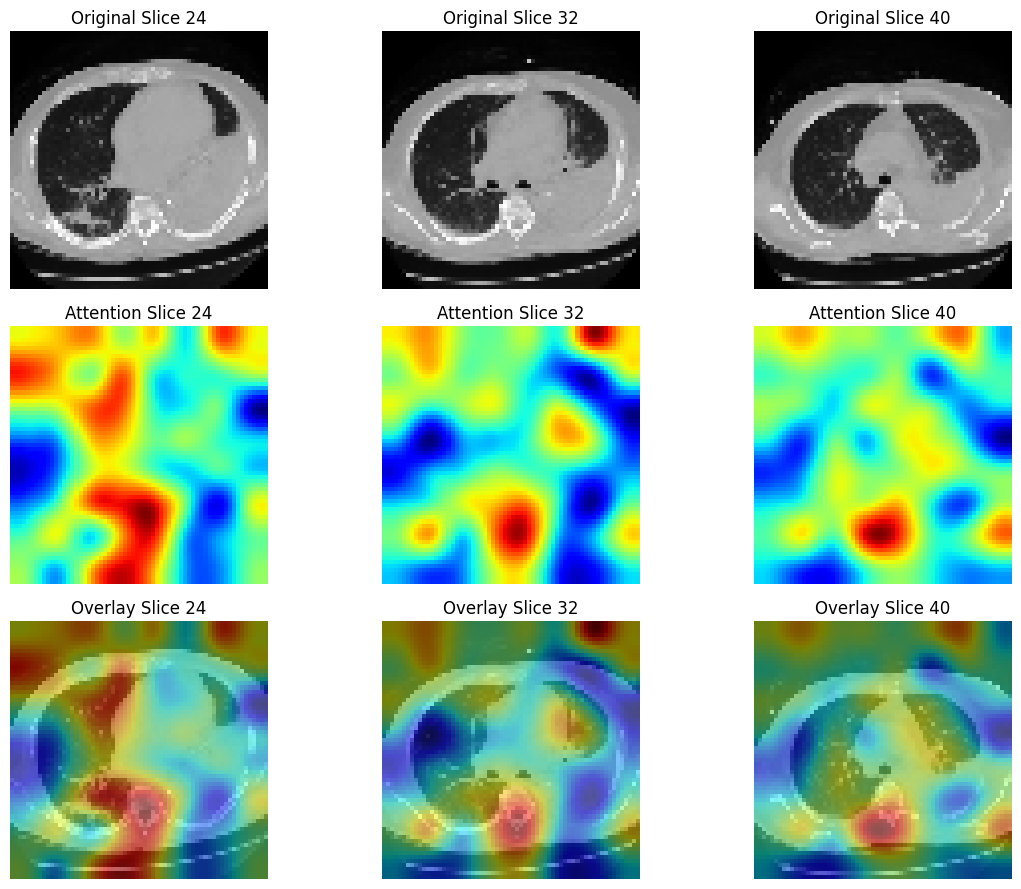

In [4]:
# Select slices for visualization
num_slices = generated_image.shape[2]  # Depth of the image (D)
selected_slices = [24, num_slices // 2, 40]  # Select three slices

plt.figure(figsize=(12, 9))

for i, slice_idx in enumerate(selected_slices):
    original_slice = generated_image[0, :, slice_idx, :, :]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[0]  # Take the first channel if multi-channel

    # Extract and process attention slice
    attention_slice = attention_maps[:, 0, slice_idx, :, :].mean(axis=0)  # Average across attention heads

    # ⚠️ Ensure the attention slice is squeezed properly to avoid errors
    if len(attention_slice.shape) > 2:
        attention_slice = attention_slice.squeeze()

    # Resize attention map to match original image dimensions (64x64)
    attention_slice_resized = cv2.resize(attention_slice, (64, 64), interpolation=cv2.INTER_CUBIC)
    attention_slice_resized = np.flipud(attention_slice_resized)  # Flip upside down

    # Flip images upside down
    original_slice = np.flipud(original_slice)
    # attention_slice_resized = np.flipud(attention_slice_resized)
    # Overlay attention
    overlay = overlay_attention_on_slice(original_slice, attention_slice_resized)
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

    # ✅ Display Heatmap
    plt.subplot(3, len(selected_slices), i + 1 + len(selected_slices))
    plt.imshow(attention_slice_resized, cmap="jet")
    plt.title(f"Attention Slice {slice_idx}")
    plt.axis("off")

    # ✅ Display Overlay
    plt.subplot(3, len(selected_slices), i + 1 + 2 * len(selected_slices))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Overlay Slice {slice_idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

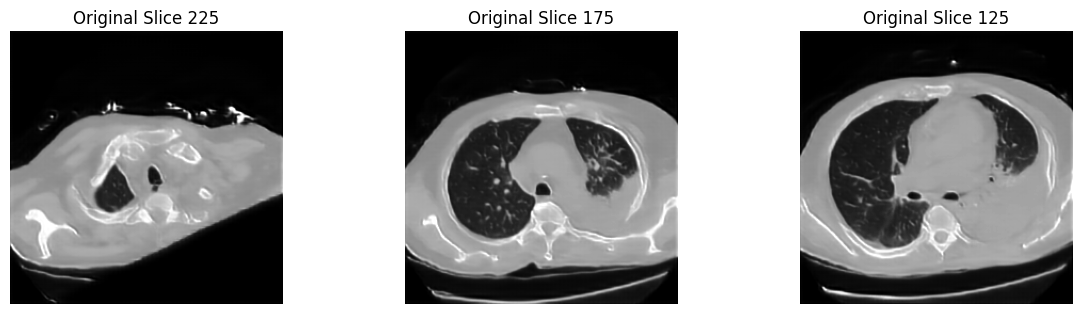

In [6]:
import nibabel as nib 

generated_highres_filename = "386525192_sample_1.nii.gz"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_256_standard/"
image_path = os.path.join(output_folder, generated_highres_filename)

nii_img = nib.load(image_path)

# Convert NIfTI to NumPy array
nii_data = nii_img.get_fdata()  # Shape: (depth, height, width)
nii_data.shape

num_slices_high_res = nii_data.shape[2]
selected_slices_high_res = [225, 175, 125]  # Select three slices

plt.figure(figsize=(12, 9))

for i, slice_idx in enumerate(selected_slices_high_res):
    original_slice = nii_data[:, :, slice_idx]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[:, :, 0]  # Take the first channel if multi-channel
        
    # Flip images upside down
    original_slice = (np.rot90(original_slice))
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()